#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import os, sys

from pathlib import Path
sys.path.append(str(Path('.ipynb').resolve().parents[2]))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def mini_batching(BATCH_SIZE, DOWNLOAD = False, SUBSET = 0):
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load dataset
    train_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                                train=True,
                                                download=DOWNLOAD,
                                                transform=train_transform,
                                                )
    test_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                                train=False,
                                                download=DOWNLOAD,
                                                transform=test_transform,
                                                )
    if SUBSET != 0:
        subset_indices = list(range(SUBSET))
        train_set = torch.utils.data.Subset(train_dataset, subset_indices)
        test_set = torch.utils.data.Subset(test_dataset, subset_indices)
        print(f"Using a subset of {SUBSET} samples for training and testing.")
    else:
        train_set, test_set = train_dataset, test_dataset
        print("Using the full dataset for training and testing.")

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, test_loader

cuda


In [2]:
def save_performance(save_path, method,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step, lr, batch_size):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    lr = str(lr).replace('.', '')

    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step,
        'lr':lr,
        'batch_size':batch_size,
    }
    with open(f'{save_path}/{method}_{n_step}_{lr}_{batch_size}.json', 'w') as f:
        json.dump(performance, f, indent=4)
    

In [3]:
def evaluate_model(model, criterion, test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
import os, json

def viz_scores(scores_path, threshold):
    contents = os.walk(scores_path)
    lr_runtime, lr_epochs, runtimes, epochs, lrs = {}, {}, [], [], []
    train_loss_dict = {}
    train_acc_dict = {}

    for root, dirs, files in contents:
        for f in files:
            if f.endswith("json"):
                _path = os.path.join(root, f)
                with open(_path, 'r') as file:
                    data = json.load(file)
                lrs.append(float(data['n_step'][0] + '.' + data['n_step'][1:]))
                runtimes.append(sum(data['run_time']))
                epochs.append(len(data['run_time']))

                train_loss_dict[data['n_step']] = data['train_losses']
                train_acc_dict[data['n_step']] = data['train_accs']
    lr_runtime['lr'] = lrs
    lr_runtime['run_time'] = runtimes
    lr_epochs['lr'] = lrs
    lr_epochs['nepochs'] = epochs
    
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(lr_runtime['lr'], lr_runtime['run_time'], label='Runtime', marker='o',linestyle='', color='blue', alpha=.5)
    ax2.plot(lr_epochs['lr'], lr_epochs['nepochs'], label='Epochs', marker='o', linestyle='', color='red', alpha=.5)

    ax1.set_ylabel('Runtime (s)')
    ax2.set_ylabel('Epochs')

    ax1.set_xlabel('Stepsize')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.title(f'Step size evaluation to get {threshold}% train acc')
    plt.grid(True)
    plt.show()
    return train_loss_dict, train_acc_dict

In [5]:
from pathlib import Path
str(Path('.ipynb').resolve().parents[2])

'/home/tung5534/cnn_cifar'

In [8]:
import os, sys
from pathlib import Path

sys.path.append(str(Path('.ipynb').resolve().parents[2]))

from models import SimpleCNN
from optim.sgd_sngl import OneStepSGD
from optim.sgd_mult import ManyStepSGD
from optim.fista_wo_prox import FISTA
from optim.fista_multi_wo_prox import FISTA

import time 

def modeling(train_loader, test_loader, n_step=2, n_epochs=15, 
             lr=0.133, momentum=0, threshold=90,
            method='sgd'):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if n_step == 1 and method=='sgd':
        optimizer = OneStepSGD(model.parameters(), lr=lr, momentum=momentum)
    elif n_step >1 and method=='sgd':
        optimizer = ManyStepSGD(model.parameters(), lr=lr, momentum=momentum, n_step=n_step)
    elif n_step == 1 and method=='fista':
        optimizer = FISTA(model.parameters(), lr=lr)
    elif n_step > 1 and method=='fista':
        optimizer = FISTA(model.parameters(), lr=lr, ministeps = n_step)

    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []
    
    def closure():
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        return loss
    
    for i, epoch in enumerate(range(n_epochs)):
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            if n_step == 1:
                # Forward
                outputs = model(images)
                loss = criterion(outputs, labels)
                # Backward
                loss.backward()
                optimizer.step()
                
            else:
                # Forward
                outputs = model(images)
                # Backward
                loss = optimizer.step(closure)

            running_loss += loss.item()
            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        run_time = time.time() - _start

        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)
        
        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train acc {epoch_train_acc:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

In [13]:
from plot import metrics_plot
n_epochs = 30
n_step = 1
lr = 0.133
threshold = 85
method='sgd' # or 'fista'

BATCH_SIZES = [32, 64, 96, 128, 192, 256, 512, 1024, 2048, 4096] 
for batch_size in BATCH_SIZES:
    print("-"*50, batch_size)
    train_loader, test_loader = mini_batching(batch_size)
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                               n_epochs=n_epochs, 
                                                                                               lr=lr,
                                                                                               threshold=threshold,
                                                                                               train_loader=train_loader,
                                                                                               test_loader=test_loader,
                                                                                               method=method
                                                                                      )
    save_path = 'scores/E30T85_1STEPS'
    method = 'SGD'
    save_performance(save_path, method,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step, lr, batch_size
                     )
#     actual_nepochs = len(train_losses)
#     metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

-------------------------------------------------- 32
Using the full dataset for training and testing.
E [1/30]. train_loss_acc: 1.5623, 43.11%, test_acc: 56.86%, run_time: 8.777543544769287
E [2/30]. train_loss_acc: 1.0912, 61.42%, test_acc: 67.70%, run_time: 8.6638662815094
E [3/30]. train_loss_acc: 0.9108, 68.26%, test_acc: 64.24%, run_time: 8.696441650390625
E [4/30]. train_loss_acc: 0.8144, 71.47%, test_acc: 73.87%, run_time: 8.873425483703613
E [5/30]. train_loss_acc: 0.7549, 73.74%, test_acc: 75.98%, run_time: 8.860748767852783
E [6/30]. train_loss_acc: 0.7102, 75.19%, test_acc: 76.95%, run_time: 8.867002487182617
E [7/30]. train_loss_acc: 0.6730, 76.56%, test_acc: 77.21%, run_time: 8.850714683532715
E [8/30]. train_loss_acc: 0.6348, 78.06%, test_acc: 76.57%, run_time: 8.886605262756348
E [9/30]. train_loss_acc: 0.6052, 78.98%, test_acc: 77.98%, run_time: 8.87230372428894
E [10/30]. train_loss_acc: 0.5841, 79.70%, test_acc: 75.14%, run_time: 8.878004550933838
E [11/30]. train_lo

## Compare Default SGD vs 3-step SGD among different mini-batch sizes

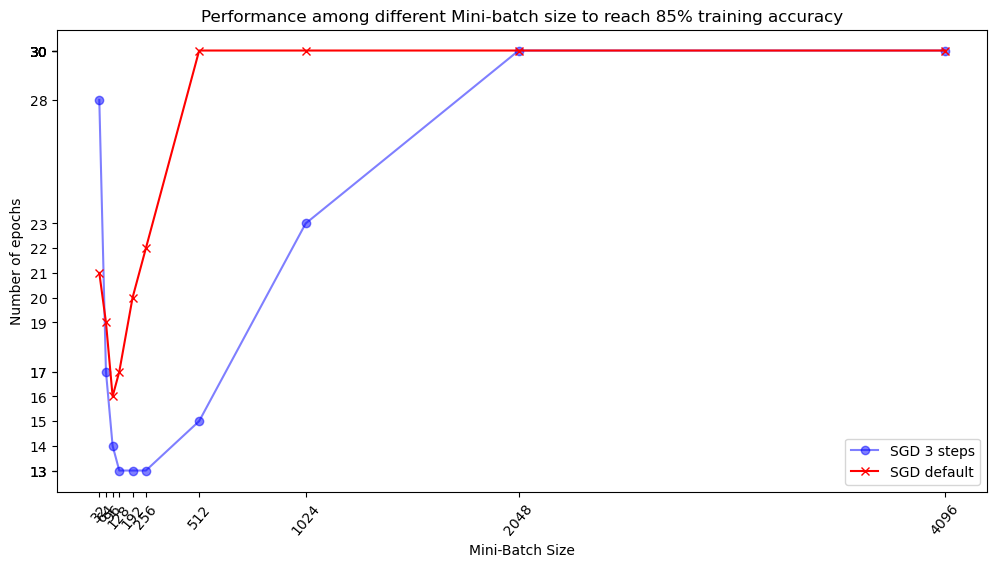

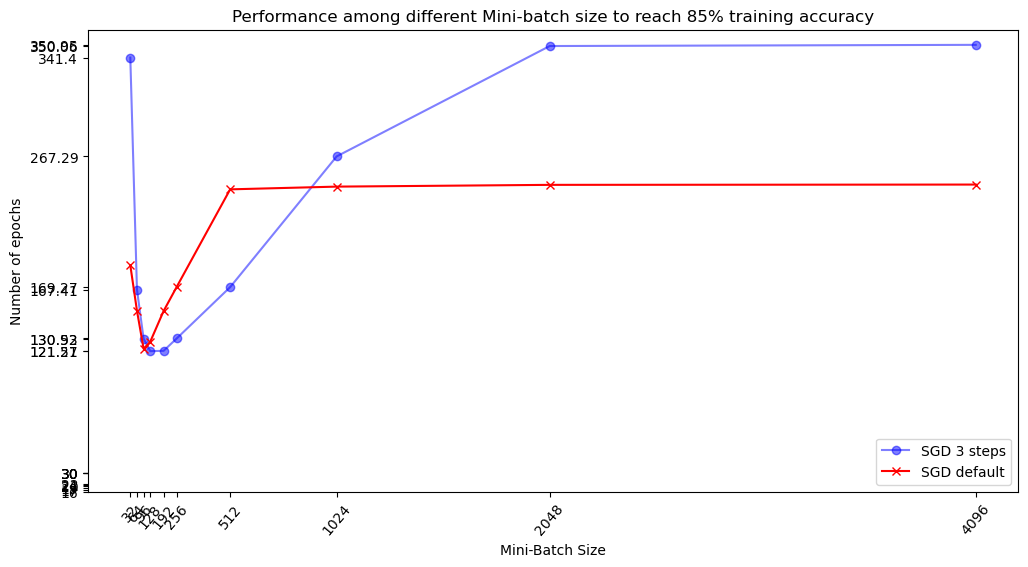

In [15]:
import os, json
import matplotlib.pyplot as plt

def load_performance(score_path):
    epochs = {}
    run_times = {}
    for root, dirs, files in os.walk(score_path):
        for file in files:
            if file.endswith('.json'):
                with open(root+file, 'r') as f:
                    data = json.load(f)
                    batch_size = data['batch_size']
                    n_epoch = len(data['train_losses'])
                    run_times[batch_size] = sum(data['run_time'])
                    epochs[batch_size] = n_epoch
    batch_sizes = sorted(list(epochs.keys()))
    n_epochs = [epochs[k] for k in batch_sizes]
    _run_time = [round(run_times[k], 2) for k in batch_sizes]
    return batch_sizes, n_epochs, _run_time

score_path_1 = "/home/tung5534/cnn_cifar/W08/optimal_batch_size/scores/E30T85_3STEPS/"
batch_sizes_3steps, n_epochs_3steps, run_time_3steps = load_performance(score_path_1)

score_path_2 = "/home/tung5534/cnn_cifar/W08/optimal_batch_size/scores/E30T85_1STEPS/"
batch_sizes_1steps, n_epochs_1steps, run_time_1steps = load_performance(score_path_2)

plt.figure(figsize=(12,6))
plt.plot(batch_sizes_3steps, n_epochs_3steps, marker='o', color='b', alpha=.5, label='SGD 3 steps')
plt.plot(batch_sizes_1steps, n_epochs_1steps, marker='x', color='r', alpha=1, label='SGD default')
plt.xlabel('Mini-Batch Size')
plt.xticks(batch_sizes_3steps, labels=batch_sizes_3steps, rotation=50)
plt.ylabel('Number of epochs')
y_tickslabel = n_epochs_3steps + n_epochs_1steps
plt.yticks(y_tickslabel, labels=y_tickslabel, rotation=0)
plt.title('Performance among different Mini-batch size to reach 85% training accuracy')
plt.legend(loc= 'lower right')
# plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(batch_sizes_3steps, run_time_3steps, marker='o', color='b', alpha=.5, label='SGD 3 steps')
plt.plot(batch_sizes_1steps, run_time_1steps, marker='x', color='r', alpha=1, label='SGD default')
plt.xlabel('Mini-Batch Size')
plt.xticks(batch_sizes_3steps, labels=batch_sizes_3steps, rotation=50)
plt.ylabel('Number of epochs')
y_tickslabel = run_time_3steps + n_epochs_1steps
plt.yticks(y_tickslabel, labels=y_tickslabel, rotation=0)
plt.title('Performance among different Mini-batch size to reach 85% training accuracy')
plt.legend(loc= 'lower right')
# plt.grid()
plt.show()

### FISTA Mini-batch Size Optimal

In [ ]:
from plot import metrics_plot
n_epochs = 30
n_step = 5
lr = 0.055
threshold = 85
method='fista' # or 'sgd'

BATCH_SIZES = [96, 128, 192, 256, 512, 1024, 2048, 4096] #32, 64, 
for batch_size in BATCH_SIZES:
    print("-"*50, batch_size)
    train_loader, test_loader = mini_batching(batch_size)
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                               n_epochs=n_epochs, 
                                                                                               lr=lr,
                                                                                               threshold=threshold,
                                                                                               train_loader=train_loader,
                                                                                               test_loader=test_loader,
                                                                                               method=method
                                                                                      )
    save_path = 'scores/E30T85_FISTA_5STEPS'
    method = 'FISTA'
    save_performance(save_path, method,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step, lr, batch_size
                     )